In [1]:
import time
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

sns.set(style='whitegrid')
plt.rcParams["figure.figsize"]=(20, 10)
pd.set_option('display.float_format', lambda x: '%f' % x)

### Clustering

A cluster refers to a collection of data points aggregated together because of certain similarities.

c:\users\konrad ulman\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(
c:\users\konrad ulman\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(
c:\users\konrad ulman\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' h

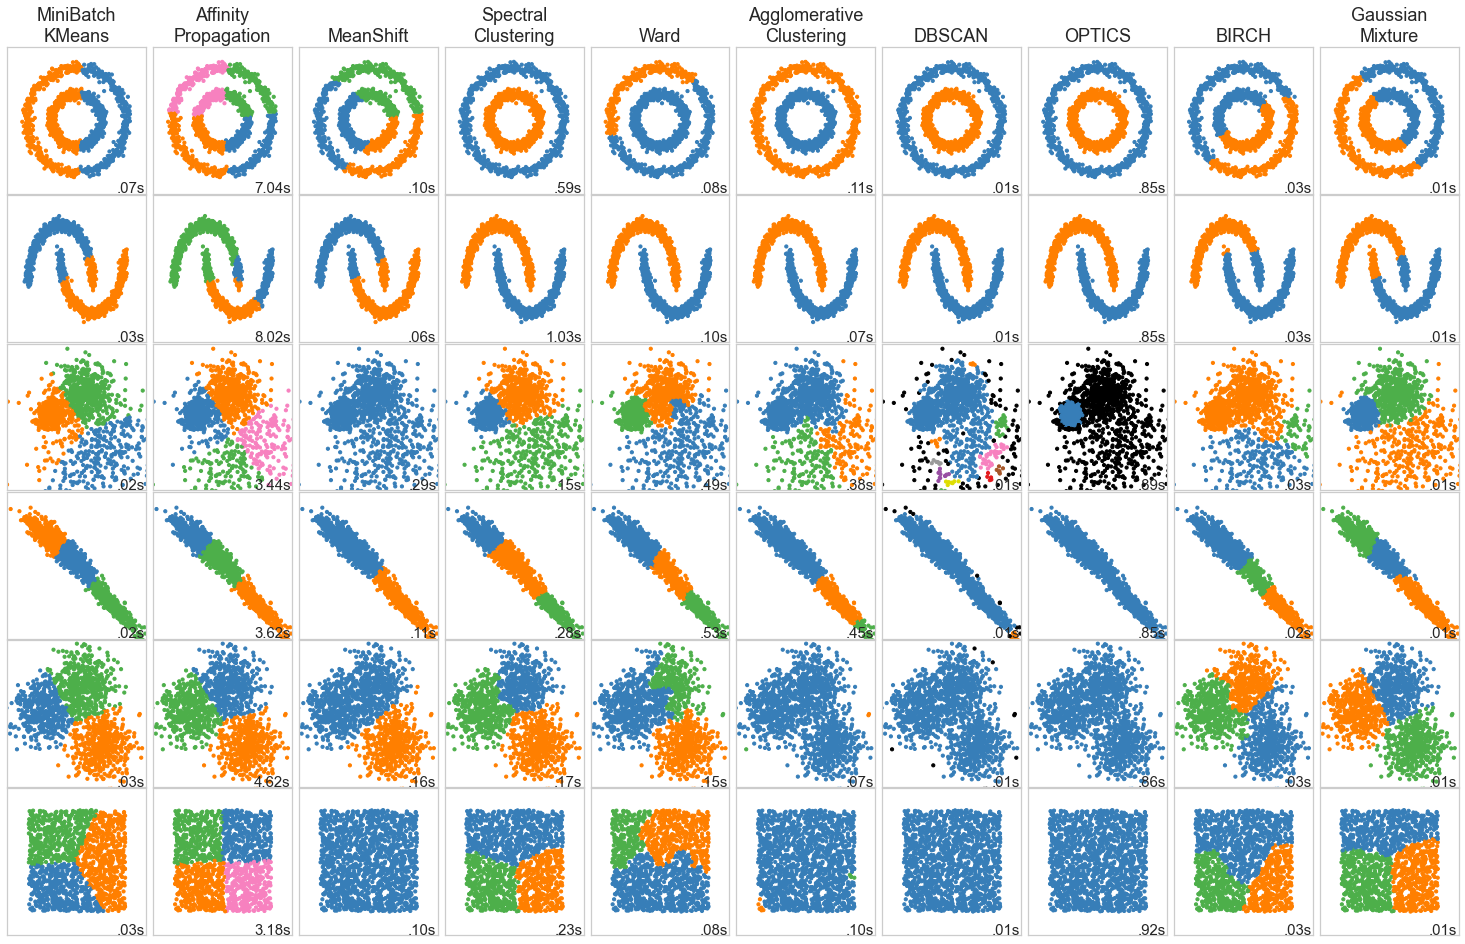

In [2]:
# ============
# Sklearn - Comparing different clustering algorithms on toy datasets
# ============

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=0)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=n_samples, random_state=0)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=0)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

ds = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(ds):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(ds), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

#### K-Means clustering

K-Means clustering method is one of the most used and popular ones. It tries to group similar points together, and discover patterns between them, by looking for a number (k) of clusters in a dataset.

In [3]:
X, Y = datasets.load_iris(return_X_y=True)

Text(0, 0.5, 'Sepal Width')

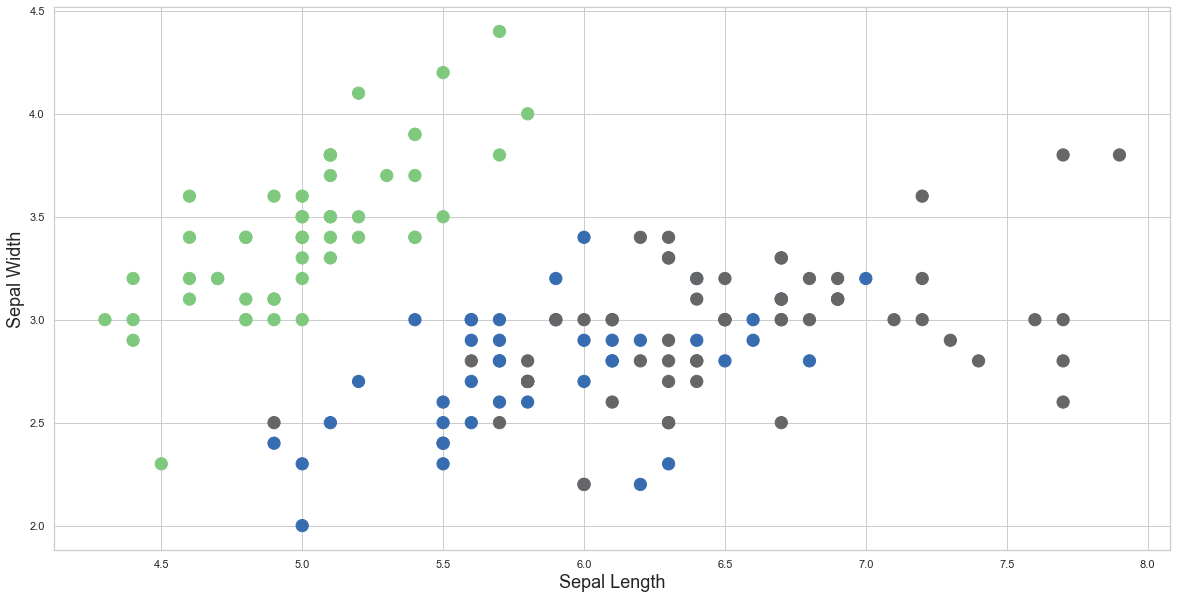

In [4]:
plt.scatter(X[:,0], X[:,1], c=Y, cmap = 'Accent', s=150)
plt.xlabel('Sepal Length', fontsize=18)
plt.ylabel('Sepal Width', fontsize=18)

In [5]:
km = KMeans(n_clusters=3, random_state=0).fit(X, Y)

Text(0.5, 1.0, 'Predicted')

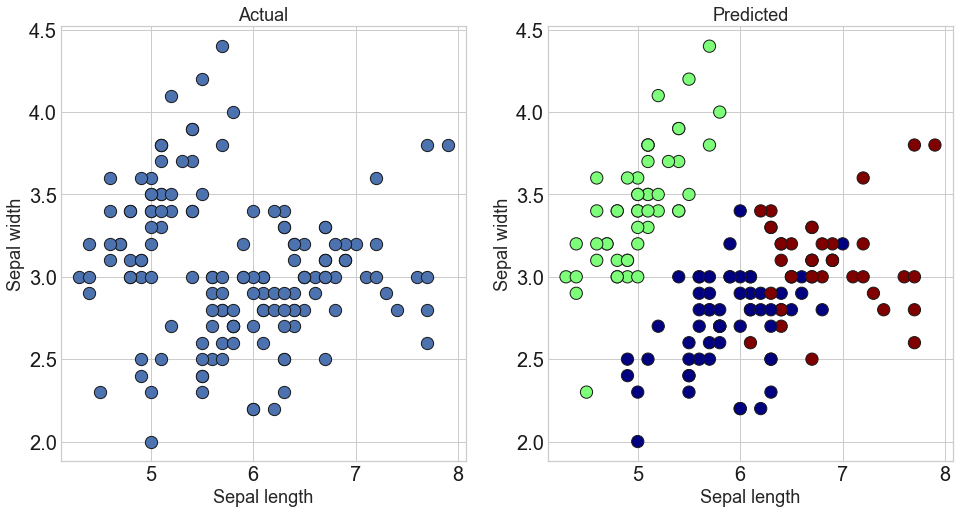

In [6]:
new_labels = km.labels_
# Plot the identified clusters and compare with the answers
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='gist_rainbow',edgecolor='k', s=150)
axes[1].scatter(X[:, 0], X[:, 1], c=new_labels, cmap='jet',edgecolor='k', s=150)
axes[0].set_xlabel('Sepal length', fontsize=18)
axes[0].set_ylabel('Sepal width', fontsize=18)
axes[1].set_xlabel('Sepal length', fontsize=18)
axes[1].set_ylabel('Sepal width', fontsize=18)
axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Predicted', fontsize=18)

<ipython-input-7-d29859e11b6e>:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


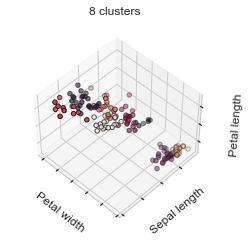

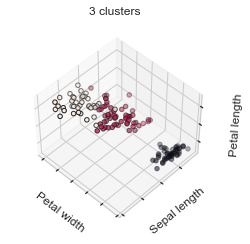

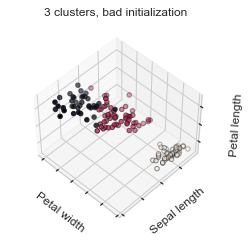

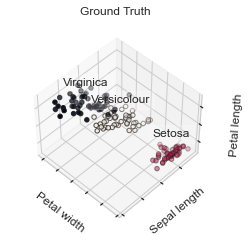

In [7]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [('k_means_iris_8', KMeans(n_clusters=8)),
              ('k_means_iris_3', KMeans(n_clusters=3)),
              ('k_means_iris_bad_init', KMeans(n_clusters=3, n_init=1,
                                               init='random'))]

fignum = 1
titles = ['8 clusters', '3 clusters', '3 clusters, bad initialization']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2],
               c=labels.astype(float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Ground Truth')
ax.dist = 12

fig.show()

### Kernel density estimation

<AxesSubplot:xlabel='total_bill', ylabel='Density'>

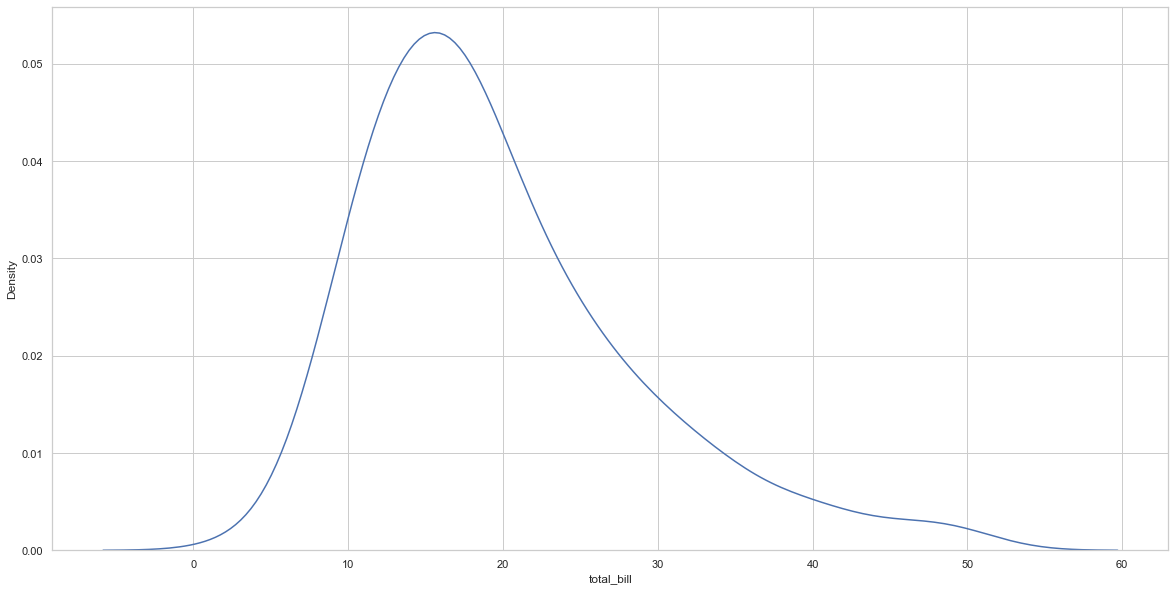

In [8]:
tips = sns.load_dataset("tips")
sns.kdeplot(data=tips, x="total_bill")

### Outlier detection

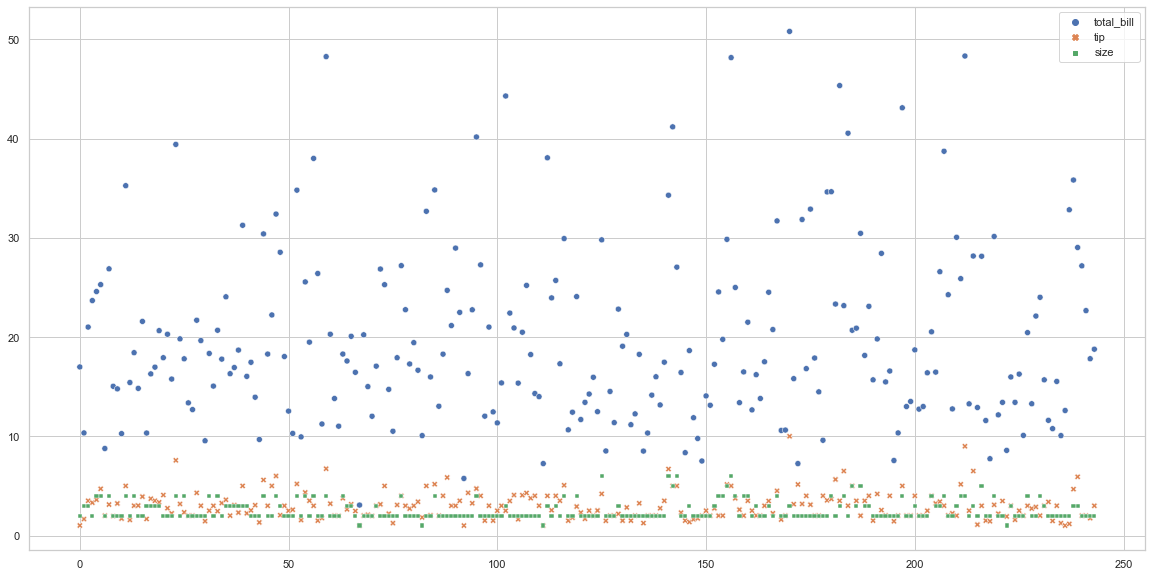

In [9]:
sns.scatterplot(data=tips)
plt.show()

In [10]:
z = np.abs(stats.zscore(tips.total_bill))

In [11]:
print("Number of records with z-score higher than 3: {}".format(len(np.where(z > 3)[0])))
print("Number of records with z-score lower than 3: {}".format(len(np.where(z < 3)[0])))

Number of records with z-score higher than 3: 4
Number of records with z-score lower than 3: 240


In [12]:
tips_z_score = tips[z < 3]

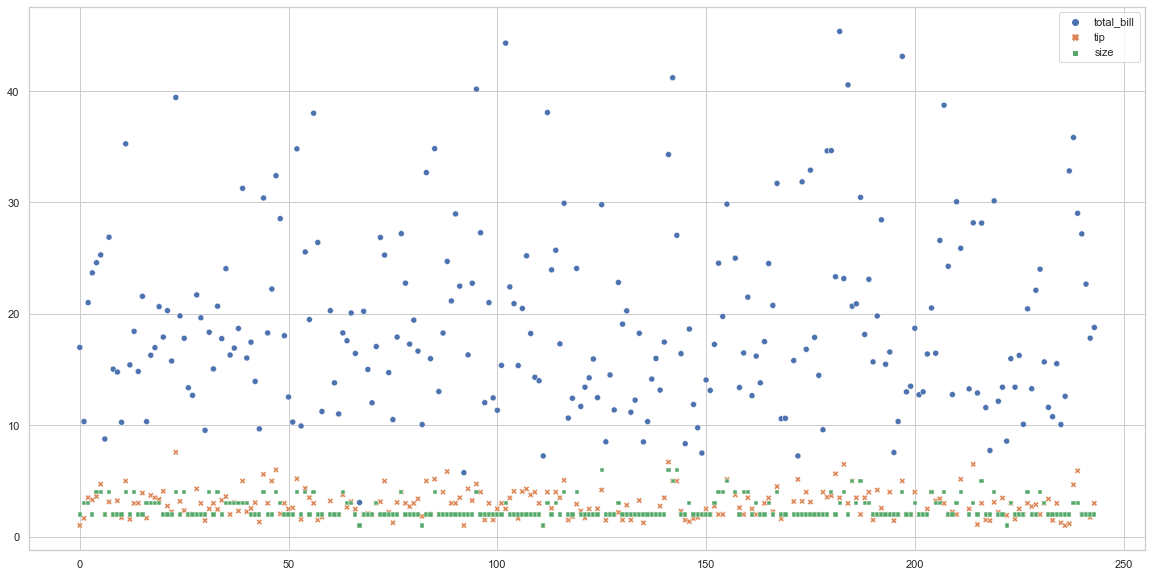

In [13]:
sns.scatterplot(data=tips_z_score)
plt.show()

In [14]:
q1 = tips.quantile(0.25)
q3 = tips.quantile(0.75)
iqr = q3 - q1

In [15]:
print(iqr)

total_bill   10.780000
tip           1.562500
size          1.000000
dtype: float64


In [16]:
tmp = (tips.total_bill < (q1.total_bill - 1.5 * iqr.total_bill)) | (tips.total_bill > (q3.total_bill + 1.5 * iqr.total_bill))
print("Number of records with IQR score indicating outlier: {}".format(len(np.where(tmp)[0])))

Number of records with IQR score indicating outlier: 9


In [17]:
tips_iqr = tips[~((tips.total_bill < (q1.total_bill - 1.5 * iqr.total_bill)) | (tips.total_bill > (q3.total_bill + 1.5 * iqr.total_bill)))]

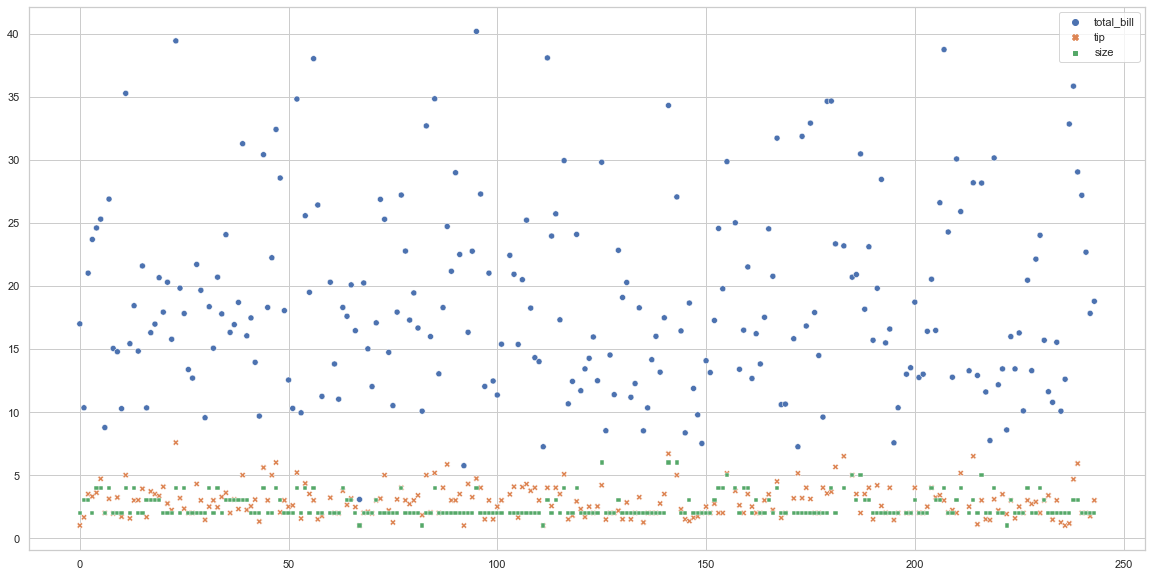

In [18]:
sns.scatterplot(data=tips_iqr)
plt.show()

### Feature selection

In [19]:
df = datasets.load_iris(as_frame=True)
X, Y = datasets.load_iris(return_X_y=True)

In [20]:
X_new = SelectKBest(chi2, k=2).fit(X, y)
X_new.scores_

array([ 10.81782088,   3.7107283 , 116.31261309,  67.0483602 ])

In [21]:
features = pd.DataFrame(X_new.scores_)
cols = pd.DataFrame(df.feature_names)

In [22]:
featureScores = pd.concat([cols, features], axis=1)
featureScores.columns = ['features', 'scores']
featureScores

,features,scores
0,sepal length (cm),10.817821
1,sepal width (cm),3.710728
2,petal length (cm),116.312613
3,petal width (cm),67.048360


### Dimensionality reduction

The number of input variables or features for a dataset is referred to as its dimensionality.
Dimensionality reduction refers to techniques that reduce the number of input variables in a dataset.

In [23]:
X, y = datasets.load_digits(return_X_y=True)

Reduce to 2 dimensions

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

In [25]:
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=0))

In [26]:
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

In [27]:
nca = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(n_components=2, random_state=0))

Classifier

In [28]:
knn = KNeighborsClassifier(n_neighbors=3)

In [29]:
def reduce_dimensions(name, model):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap='Set1')
    plt.title("{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, 3, acc_knn))

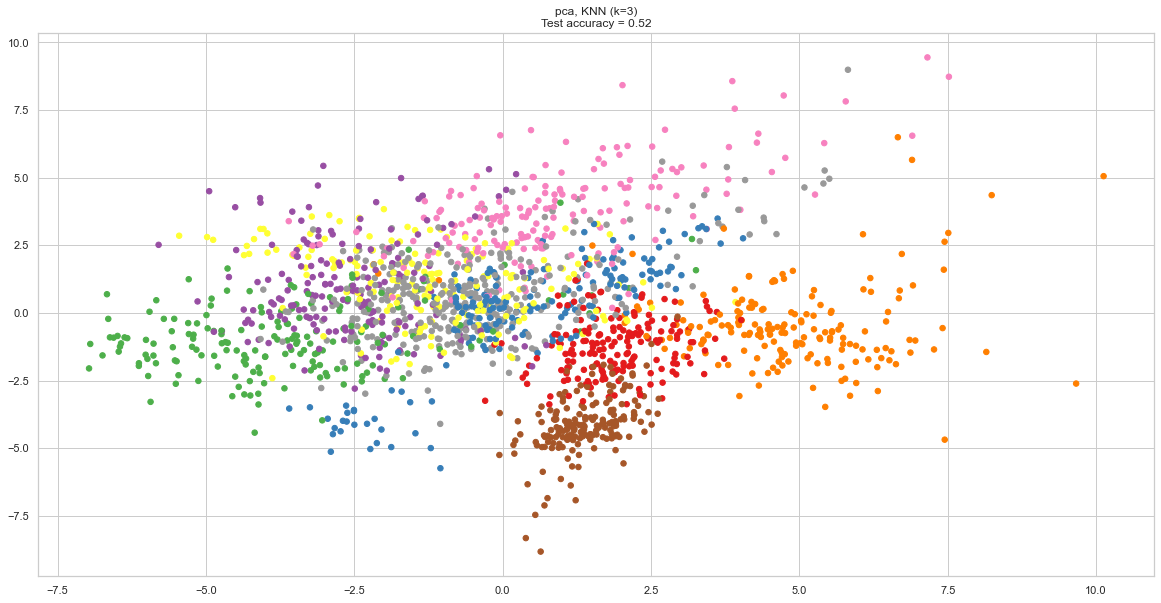

In [30]:
reduce_dimensions('pca', pca)

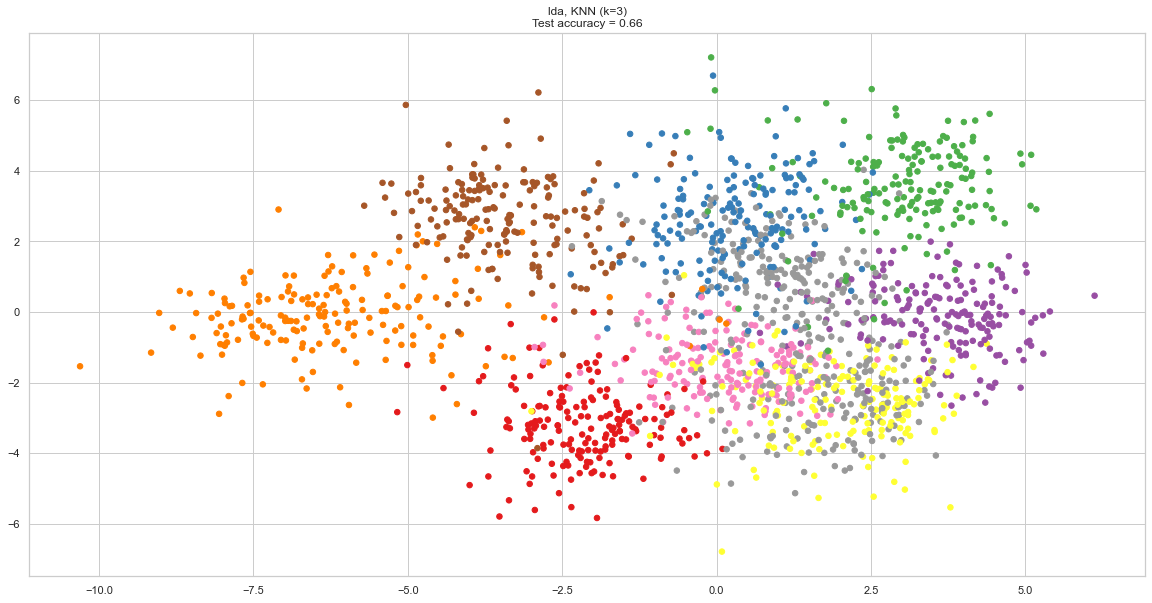

In [31]:
reduce_dimensions('lda', lda)

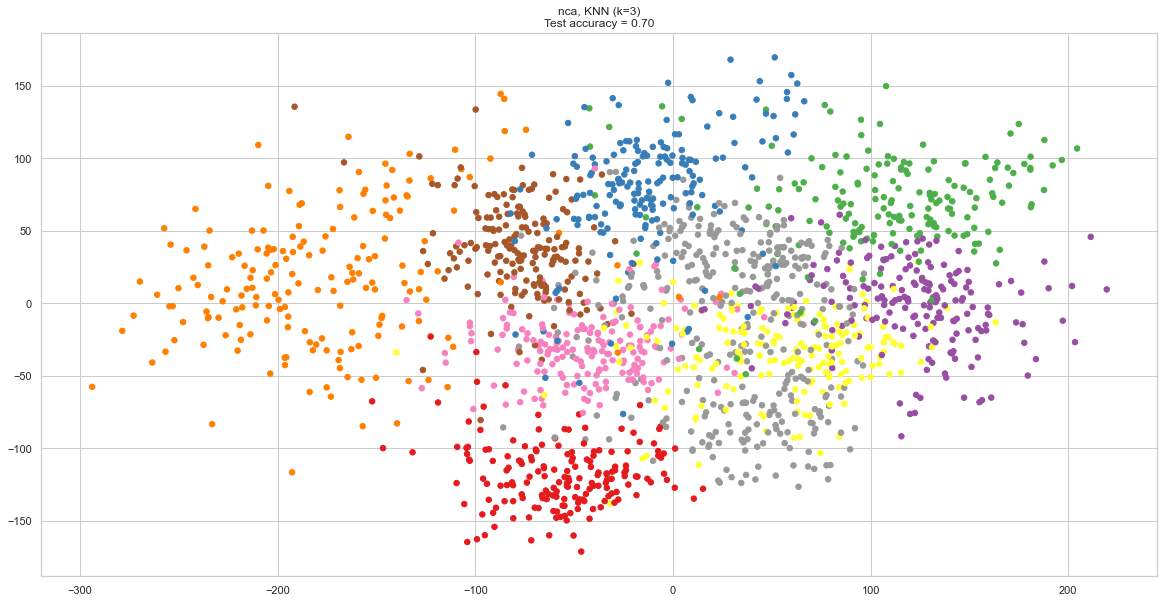

In [32]:
reduce_dimensions('nca', nca)

### Bagging